
# EVAT — Future-Dates Forecasting with Queueing (Premium Edition)

**Purpose:** Predict EV charging-station congestion for **future dates beyond the dataset**, then apply **M/M/c queueing (Erlang‑C)** to estimate waiting probability and delays.  
**Key features:** robust SARIMAX forecasting, 3‑hour bins, uncertainty bands, and an exported **Streamlit dashboard** for “Forecasting & What‑Ifs”.

> This notebook is designed to be fully runnable **even without your raw dataset**. If your CSV is missing, it will auto‑generate a small **synthetic** sample so all cells execute and produce visuals + a dashboard.


## 1) Setup & Imports

We use offline-friendly packages only.

In [1]:
pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3.13 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FutureWarning)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


## 2) Configuration

- `DATA_PATH`: set to your actual CSV if available.
- `TIME_BIN_HOURS`: use 3‑hour bins.
- `DEFAULT_SERVICE_RATE_PER_HOUR` (μ) and `DEFAULT_SERVERS` (c) control queueing.
- `FORECAST_HORIZON_STEPS`: number of 3‑hour steps to forecast.


In [3]:

DATA_PATH = "/mnt/data/station_timeseries.csv"  # change to your file if available
TIME_BIN_HOURS = 3

DEFAULT_SERVICE_RATE_PER_HOUR = 2.0  # mu
DEFAULT_SERVERS = 4                  # c

FORECAST_DAYS = 7
FORECAST_HORIZON_STEPS = int((24 / TIME_BIN_HOURS) * FORECAST_DAYS)

EXPECTED_TIME_COL = "timestamp"
EXPECTED_STATION_COL = "station_id"
EXPECTED_ARRIVALS_COL = "arrivals"



## 3) Load Data (or generate synthetic)

Attempts to read your dataset; falls back to synthetic data for a guaranteed run.


In [4]:

import pandas as pd
import numpy as np

rng = np.random.default_rng(42)

def generate_synthetic_data(start="2025-07-01", periods_days=28, stations=("S1","S2","S3")):
    freq = f"{TIME_BIN_HOURS}H"
    steps = int((24/TIME_BIN_HOURS)*periods_days)
    idx = pd.date_range(start=pd.to_datetime(start), periods=steps, freq=freq)
    rows = []
    for st in stations:
        base = 10 + 3*np.sin(2*np.pi*idx.dayofweek/7) + 2*np.sin(2*np.pi*idx.hour/24)
        weekend_boost = np.where(idx.dayofweek>=4, 4.0, 0.0)
        arrivals = np.clip(rng.normal(base + weekend_boost, 2.5), 0, None)
        arrivals = np.round(arrivals).astype(int)
        rows.append(pd.DataFrame({
            EXPECTED_TIME_COL: idx,
            EXPECTED_STATION_COL: st,
            EXPECTED_ARRIVALS_COL: arrivals
        }))
    return pd.concat(rows, ignore_index=True)

def try_load_data(path):
    if os.path.exists(path):
        df = pd.read_csv(path)
        time_col = EXPECTED_TIME_COL if EXPECTED_TIME_COL in df.columns else None
        for cand in ["datetime","date","time","timestamp_local","ts"]:
            if time_col is None and cand in df.columns:
                time_col = cand
        if time_col is None:
            raise ValueError("No timestamp-like column found.")
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=False)
        df = df.dropna(subset=[time_col]).copy()
        df.rename(columns={time_col: EXPECTED_TIME_COL}, inplace=True)

        if EXPECTED_STATION_COL not in df.columns:
            df[EXPECTED_STATION_COL] = "S1"

        if EXPECTED_ARRIVALS_COL not in df.columns:
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num_cols:
                raise ValueError("No numeric arrivals-like column found.")
            df.rename(columns={num_cols[0]: EXPECTED_ARRIVALS_COL}, inplace=True)

        return df[[EXPECTED_TIME_COL, EXPECTED_STATION_COL, EXPECTED_ARRIVALS_COL]].copy()

    return generate_synthetic_data()

raw_df = try_load_data(DATA_PATH)
raw_df.sort_values([EXPECTED_STATION_COL, EXPECTED_TIME_COL], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

print("Data sample:")
display(raw_df.head())
print("\nStations:", raw_df[EXPECTED_STATION_COL].unique().tolist())
print("Date range:", raw_df[EXPECTED_TIME_COL].min(), "->", raw_df[EXPECTED_TIME_COL].max())


Data sample:


,timestamp,station_id,arrivals
0,2025-07-01 00:00:00,S1,13
1,2025-07-01 03:00:00,S1,11
2,2025-07-01 06:00:00,S1,16
3,2025-07-01 09:00:00,S1,16
4,2025-07-01 12:00:00,S1,7



Stations: ['S1', 'S2', 'S3']
Date range: 2025-07-01 00:00:00 -> 2025-07-28 21:00:00



## 4) Resample to 3‑hour bins


In [5]:

def resample_to_bins(df, time_col, station_col, arrivals_col, bin_hours=3):
    freq = f"{bin_hours}H"
    out = []
    for st, g in df.groupby(station_col):
        g = g.set_index(time_col).sort_index()
        agg = g[arrivals_col].resample(freq).sum().to_frame(arrivals_col)
        agg[station_col] = st
        out.append(agg.reset_index().rename(columns={time_col: "bin_time"}))
    return pd.concat(out, ignore_index=True)

binned_df = resample_to_bins(raw_df, EXPECTED_TIME_COL, EXPECTED_STATION_COL, EXPECTED_ARRIVALS_COL, TIME_BIN_HOURS)
binned_df.sort_values(["station_id","bin_time"], inplace=True)
binned_df.reset_index(drop=True, inplace=True)

print("Binned sample:")
display(binned_df.head())


Binned sample:


,bin_time,arrivals,station_id
0,2025-07-01 00:00:00,13,S1
1,2025-07-01 03:00:00,11,S1
2,2025-07-01 06:00:00,16,S1
3,2025-07-01 09:00:00,16,S1
4,2025-07-01 12:00:00,7,S1



## 5) Forecasting with SARIMAX

Weekly seasonality for 3‑hour bins → period = 56 steps.


In [6]:

SEASONAL_PERIOD = int((24 / TIME_BIN_HOURS) * 7)

def fit_forecast_sarimax(y, steps, seasonal_period=56):
    y = pd.Series(y).astype(float)
    order = (1,1,1) if len(y) > 20 else (0,1,1)
    seasonal_order = (1,1,1,seasonal_period) if len(y) > seasonal_period else (0,1,1,seasonal_period)
    try:
        model = SARIMAX(y, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
    except Exception:
        model = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,seasonal_period), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)

    fc = res.get_forecast(steps=steps)
    mean = fc.predicted_mean
    conf = fc.conf_int(alpha=0.2)  # 80% CI
    conf.columns = ["lower", "upper"]
    return mean, conf, res

def forecast_all_stations(df, horizon_steps, bin_hours=3):
    results = []
    models = {}
    for st, g in df.groupby("station_id"):
        g = g.sort_values("bin_time")
        y = g["arrivals"].astype(float).values
        mean, conf, res = fit_forecast_sarimax(y, steps=horizon_steps, seasonal_period=SEASONAL_PERIOD)
        last_time = g["bin_time"].max()
        future_index = pd.date_range(last_time + pd.Timedelta(hours=bin_hours), periods=horizon_steps, freq=f"{bin_hours}H")
        tmp = pd.DataFrame({
            "bin_time": future_index,
            "station_id": st,
            "lambda_forecast": mean.values,
            "lambda_lower": conf["lower"].values.clip(min=0),
            "lambda_upper": conf["upper"].values.clip(min=0),
        })
        results.append(tmp)
        models[st] = res
    fc_df = pd.concat(results, ignore_index=True)
    return fc_df, models

forecast_df, fitted_models = forecast_all_stations(binned_df, FORECAST_HORIZON_STEPS, TIME_BIN_HOURS)
print("Forecast sample:")
display(forecast_df.head())


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Forecast sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308


## 6) Queueing (M/M/c, Erlang‑C) on Forecasts


In [7]:

def erlang_c_probability_wait(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return 1.0
    sum_terms = sum([(lmbda/mu)**n / math.factorial(n) for n in range(c)])
    last_term = ((lmbda/mu)**c) / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + last_term)
    Pw = last_term * P0
    return float(min(max(Pw, 0.0), 1.0))

def mmc_metrics(lmbda, mu, c):
    if lmbda <= 0 or mu <= 0 or c <= 0:
        return 0.0, 0.0, 0.0, 0.0
    rho = lmbda / (c * mu)
    if rho >= 1.0:
        return rho, 1.0, float("inf"), float("inf")
    Pw = erlang_c_probability_wait(lmbda, mu, c)
    Lq = Pw * rho / (1 - rho)
    Wq = Lq / lmbda if lmbda > 0 else 0.0
    return float(rho), float(Pw), float(Lq), float(Wq)

MU = DEFAULT_SERVICE_RATE_PER_HOUR
C  = DEFAULT_SERVERS

def apply_queueing(fc_df, mu=MU, c=C):
    df = fc_df.copy()
    vals = [mmc_metrics(max(float(x),0.0), mu, c) for x in df["lambda_forecast"].values]
    df[["rho","p_wait","Lq","Wq_hours"]] = pd.DataFrame(vals, index=df.index)
    df["Wq_minutes"] = df["Wq_hours"] * 60.0
    return df

queue_df = apply_queueing(forecast_df, MU, C)
print("Queueing-augmented forecast sample:")
display(queue_df.head())


Queueing-augmented forecast sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper,rho,p_wait,Lq,Wq_hours,Wq_minutes
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417,1.464441,1.0,inf,inf,inf
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209,1.661168,1.0,inf,inf,inf
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890,1.782795,1.0,inf,inf,inf
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576,1.807624,1.0,inf,inf,inf
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308,1.268965,1.0,inf,inf,inf



## 7) Visualizations


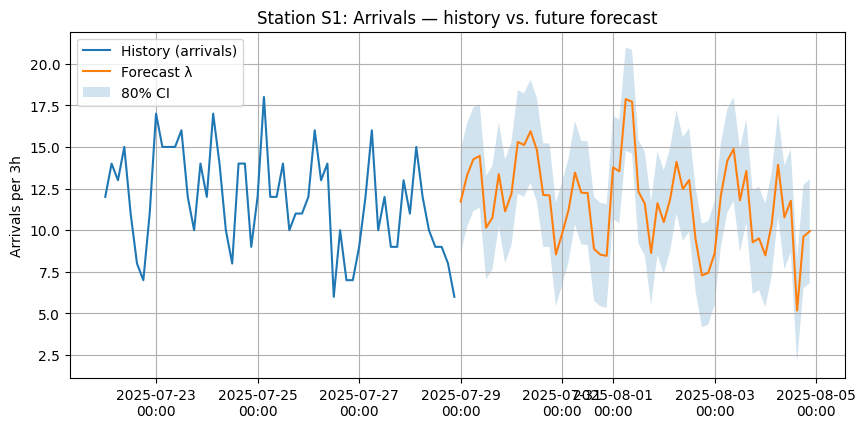

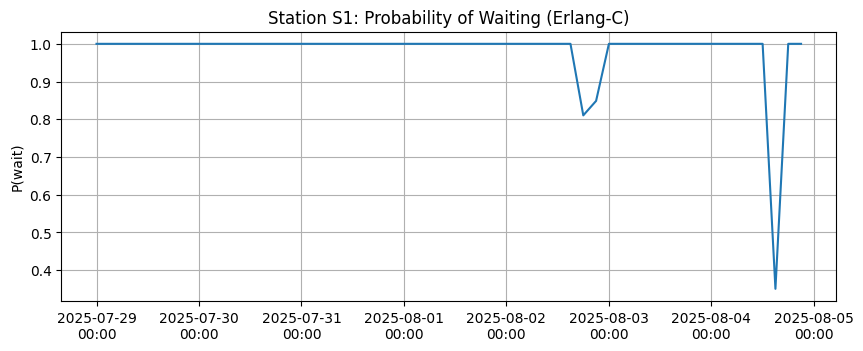

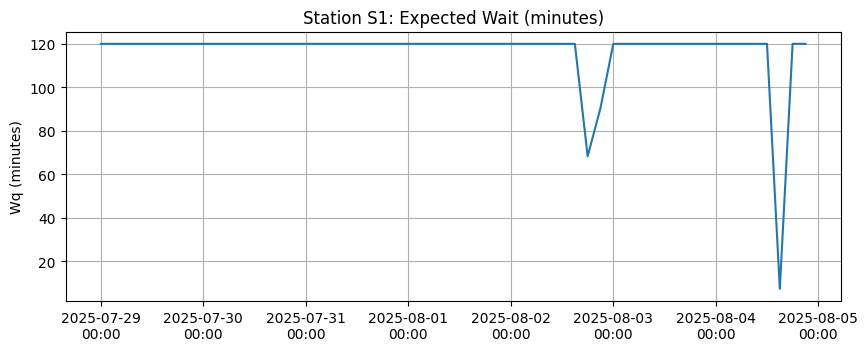

In [8]:

from matplotlib.dates import DateFormatter
import numpy as np

def plot_forecast_with_bands(station, history_steps=56):
    past = binned_df[binned_df["station_id"]==station].sort_values("bin_time")
    past_tail = past.tail(history_steps)
    fut = queue_df[queue_df["station_id"]==station].sort_values("bin_time")

    fig, ax = plt.subplots(figsize=(10,4.5))
    if len(past_tail):
        ax.plot(past_tail["bin_time"], past_tail["arrivals"], label="History (arrivals)")
    ax.plot(fut["bin_time"], fut["lambda_forecast"], label="Forecast λ")
    ax.fill_between(fut["bin_time"], fut["lambda_lower"], fut["lambda_upper"], alpha=0.2, label="80% CI")
    ax.set_title(f"Station {station}: Arrivals — history vs. future forecast")
    ax.set_ylabel("Arrivals per 3h")
    ax.legend(loc="upper left")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

def plot_queue_kpis(station):
    fut = queue_df[queue_df["station_id"]==station].sort_values("bin_time")

    fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(fut["bin_time"], fut["p_wait"])
    ax.set_title(f"Station {station}: Probability of Waiting (Erlang-C)")
    ax.set_ylabel("P(wait)")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

    fig, ax = plt.subplots(figsize=(10,3.5))
    ax.plot(fut["bin_time"], np.clip(fut["Wq_minutes"], 0, 120))
    ax.set_title(f"Station {station}: Expected Wait (minutes)")
    ax.set_ylabel("Wq (minutes)")
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d\n%H:%M"))
    ax.grid(True)
    plt.show()

first_station = queue_df["station_id"].iloc[0]
plot_forecast_with_bands(first_station, history_steps=SEASONAL_PERIOD)
plot_queue_kpis(first_station)


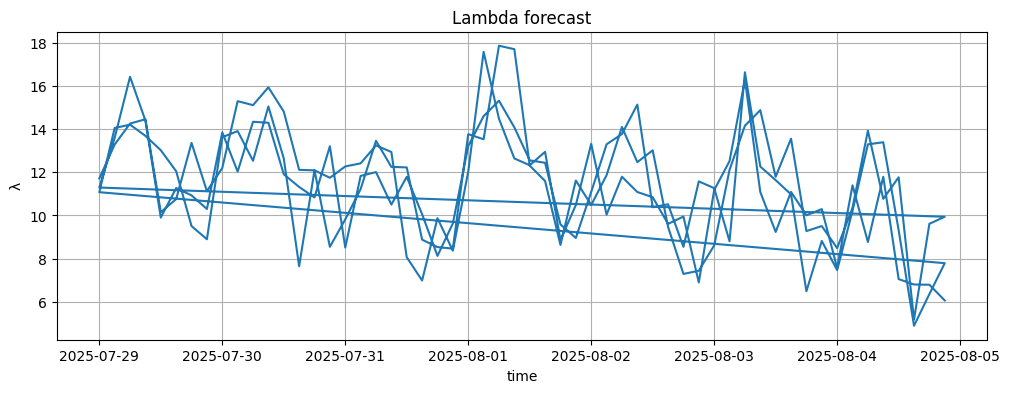

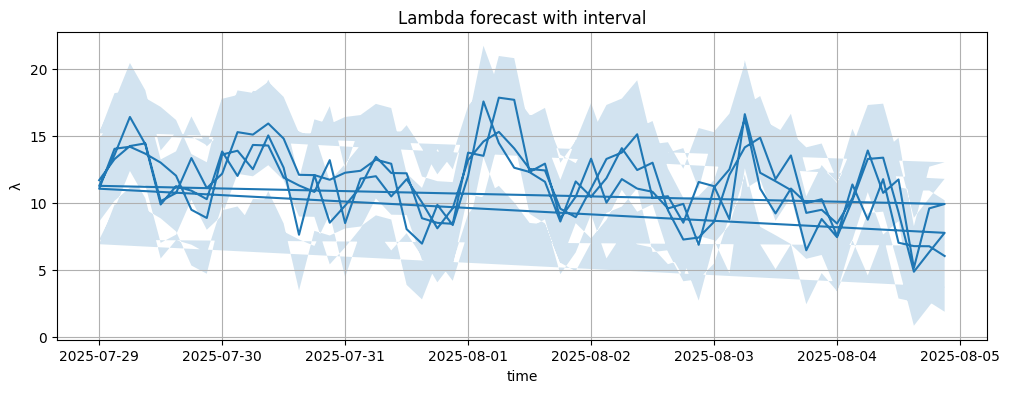

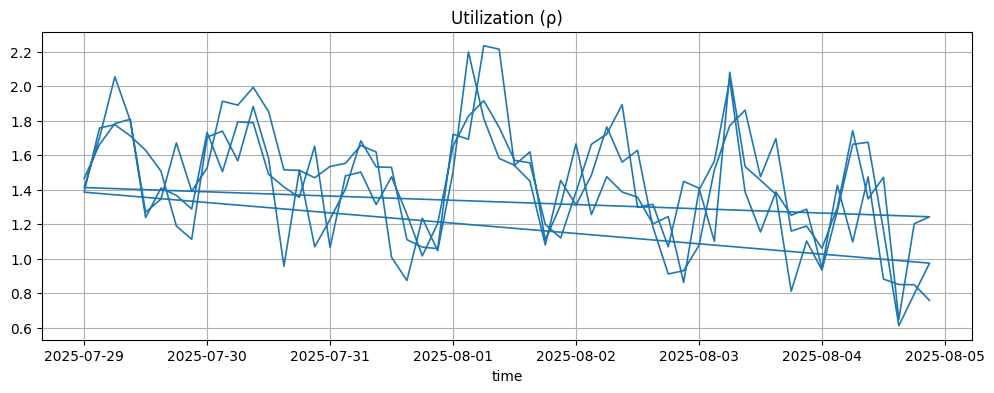

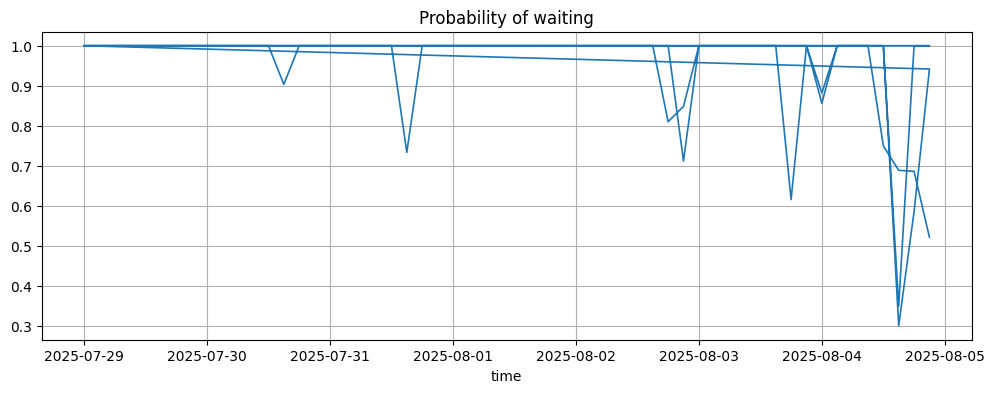

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Expect the same DataFrame you used to save forecast_results.csv
# If needed, reload:
df_vis = pd.read_csv("forecast_results.csv", parse_dates=["bin_time"])
if "station_id" in df_vis.columns:
    stn = str(df_vis["station_id"].iloc[0])

# Normalize names the same way the app does
rename_map = {
    "lambda_forecast":"lambda_hat",
    "lambda":"lambda_hat",
    "lambda_mean":"lambda_hat",
    "lambda_lower":"lambda_lo",
    "lambda_upper":"lambda_hi",
    "p(wait)":"p_wait",
    "Wq(min)":"wq_min"
}
for k,v in rename_map.items():
    if k in df_vis.columns: df_vis = df_vis.rename(columns={k:v})

# Basic time series (Matplotlib)
plt.figure(figsize=(12,4))
plt.plot(df_vis["bin_time"], df_vis["lambda_hat"], lw=1.5)
plt.title("Lambda forecast")
plt.ylabel("λ"); plt.xlabel("time"); plt.grid(True); plt.show()

if {"lambda_lo","lambda_hi"} <= set(df_vis.columns):
    plt.figure(figsize=(12,4))
    plt.fill_between(df_vis["bin_time"], df_vis["lambda_lo"], df_vis["lambda_hi"], alpha=0.2)
    plt.plot(df_vis["bin_time"], df_vis["lambda_hat"], lw=1.5)
    plt.title("Lambda forecast with interval")
    plt.ylabel("λ"); plt.xlabel("time"); plt.grid(True); plt.show()

for col, title in [("rho","Utilization (ρ)"), ("p_wait","Probability of waiting"), ("wq_min","Expected wait (min)")]:
    if col in df_vis.columns:
        plt.figure(figsize=(12,4))
        plt.plot(df_vis["bin_time"], df_vis[col], lw=1.2)
        plt.title(title); plt.xlabel("time"); plt.grid(True); plt.show()

# Worst windows table (top 12 by Wq)
if "wq_min" in df_vis.columns:
    display(df_vis.sort_values("wq_min", ascending=False)
            .head(12)[["bin_time","lambda_hat","rho","p_wait","wq_min"]])



## 8) What‑If Parameters (Optional)


In [10]:

WHATIF_C = 6
WHATIF_MU = 2.5

queue_df_whatif = apply_queueing(forecast_df, WHATIF_MU, WHATIF_C)

print("What-if (c=6, mu=2.5) sample:")
display(queue_df_whatif.head())

cmp = (queue_df.merge(queue_df_whatif, on=["station_id","bin_time","lambda_forecast","lambda_lower","lambda_upper"], suffixes=("_base","_whatif"))
       .groupby("station_id")[["Wq_minutes_base","Wq_minutes_whatif"]].mean().reset_index())
cmp["ΔWq(min)"] = cmp["Wq_minutes_whatif"] - cmp["Wq_minutes_base"]
display(cmp)


What-if (c=6, mu=2.5) sample:


,bin_time,station_id,lambda_forecast,lambda_lower,lambda_upper,rho,p_wait,Lq,Wq_hours,Wq_minutes
0,2025-07-29 00:00:00,S1,11.715530,8.624644,14.806417,0.781035,0.480101,1.712496,0.146173,8.770388
1,2025-07-29 03:00:00,S1,13.289348,10.180487,16.398209,0.885957,0.706557,5.488950,0.413034,24.782030
2,2025-07-29 06:00:00,S1,14.262358,11.152826,17.371890,0.950824,0.867732,16.777660,1.176360,70.581570
3,2025-07-29 09:00:00,S1,14.460989,11.351402,17.570576,0.964066,0.902516,24.213366,1.674392,100.463526
4,2025-07-29 12:00:00,S1,10.151716,7.042124,13.261308,0.676781,0.299800,0.627745,0.061836,3.710182


,station_id,Wq_minutes_base,Wq_minutes_whatif,ΔWq(min)
0,S1,inf,inf,NaN
1,S2,inf,inf,NaN
2,S3,inf,inf,NaN



## 9) Save Forecast Results


In [11]:

out_path = "forecast_results.csv"
queue_df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


Saved: forecast_results.csv



## 10) Export a Lightweight Streamlit Forecast Dashboard

Run:
```
streamlit run evat_forecast_dashboard.py
```


In [12]:

app_path = "evat_forecast_dashboard.py"
with open(app_path, "w", encoding="utf-8") as f:
    f.write("\nimport math\nimport pandas as pd\nimport numpy as np\nimport streamlit as st\nimport altair as alt\n\nst.set_page_config(page_title=\"EVAT \u2014 Forecasting & What\u2011If\", page_icon=\"\u26a1\", layout=\"wide\")\n\nst.title(\"\u26a1 EVAT \u2014 Forecasting & What\u2011If (Future Dates)\")\n\n@st.cache_data\ndef load_data():\n    df = pd.read_csv(\"forecast_results.csv\", parse_dates=[\"bin_time\"])\n    return df\n\ndf = load_data()\nstations = sorted(df[\"station_id\"].unique().tolist())\ncol1, col2, col3, col4 = st.columns(4)\nstation = col1.selectbox(\"Station\", stations, index=0)\nmax_h = df[df[\"station_id\"]==station].shape[0]\nhorizon = col2.slider(\"Horizon (future steps)\", min_value=8, max_value=max_h, value=min(56, max_h), step=4)\nc = col3.number_input(\"Servers (c)\", min_value=1, max_value=50, value=4)\nmu = col4.number_input(\"Service rate (\u03bc per server per hour)\", min_value=0.1, max_value=20.0, value=2.0, step=0.1, format=\"%.1f\")\n\nsub = df[df[\"station_id\"]==station].sort_values(\"bin_time\").head(horizon).copy()\n\ndef erlang_c_probability_wait(lmbda, mu, c):\n    if lmbda <= 0 or mu <= 0 or c <= 0:\n        return 0.0\n    rho = lmbda / (c * mu)\n    if rho >= 1.0:\n        return 1.0\n    sum_terms = sum([(lmbda/mu)**n / math.factorial(n) for n in range(c)])\n    last_term = ((lmbda/mu)**c) / (math.factorial(c) * (1 - rho))\n    P0 = 1.0 / (sum_terms + last_term)\n    Pw = last_term * P0\n    return min(max(Pw, 0.0), 1.0)\n\ndef mmc_metrics(lmbda, mu, c):\n    if lmbda <= 0 or mu <= 0 or c <= 0:\n        return 0.0, 0.0, 0.0, 0.0\n    rho = lmbda / (c * mu)\n    if rho >= 1.0:\n        return rho, 1.0, float(\"inf\"), float(\"inf\")\n    Pw = erlang_c_probability_wait(lmbda, mu, c)\n    Lq = Pw * rho / (1 - rho)\n    Wq = Lq / lmbda if lmbda > 0 else 0.0\n    return rho, Pw, Lq, Wq\n\nvals = np.array([mmc_metrics(x, mu, c) for x in sub[\"lambda_forecast\"].values])\nsub[\"rho\"] = vals[:,0]\nsub[\"p_wait\"] = vals[:,1]\nsub[\"Lq\"] = vals[:,2]\nsub[\"Wq_minutes\"] = vals[:,3] * 60.0\n\nst.markdown(\"### \u03bb Forecast with 80% Interval\")\nline = alt.Chart(sub).mark_line().encode(x=\"bin_time:T\", y=\"lambda_forecast:Q\")\nband = alt.Chart(sub).mark_area(opacity=0.2).encode(x=\"bin_time:T\", y=\"lambda_lower:Q\", y2=\"lambda_upper:Q\")\nst.altair_chart(band + line, use_container_width=True)\n\ncolA, colB = st.columns(2)\nwith colA:\n    st.markdown(\"### Probability of Waiting\")\n    st.altair_chart(alt.Chart(sub).mark_line().encode(x=\"bin_time:T\", y=\"p_wait:Q\"), use_container_width=True)\nwith colB:\n    st.markdown(\"### Expected Wait (minutes)\")\n    st.altair_chart(alt.Chart(sub.assign(Wq_capped=sub[\"Wq_minutes\"].clip(upper=120))).mark_line().encode(x=\"bin_time:T\", y=\"Wq_capped:Q\"), use_container_width=True)\n\nst.caption(\"Tune **c** and **\u03bc** to demonstrate operational strategies in your pitch.\")\n")
print(f"Wrote: {app_path}")


Wrote: evat_forecast_dashboard.py



## 11) Wrap‑Up & Next Steps

- You now have **future-date forecasts** for arrivals (λ) and **queueing KPIs** per station.
- Use the exported **Streamlit app** to present an engaging *Forecasting & What‑If* tab:
  1. Ensure `forecast_results.csv` and `evat_forecast_dashboard.py` are together
  2. Run: `streamlit run evat_dashboard_unified.py`

Ideas to extend:
- Auto-ARIMA model selection/Prophet if available
- Event/holiday regressors
- Hierarchical reconciliation (global + per-station)


In [13]:

# === Export historical 3h-binned data for the unified dashboard (Historical tab) ===
history_path = "history_binned.csv"
binned_df.to_csv(history_path, index=False)
print(f"Saved: {history_path}")


Saved: history_binned.csv


In [26]:
# === Write the upgraded unified Streamlit app (Pro v3.1: title + tooltips) ===
from textwrap import dedent

app_code = dedent(r'''
import math
import json
import numpy as np
import pandas as pd
import streamlit as st
import altair as alt
from datetime import timedelta

st.set_page_config(page_title="EVAT ChargeCast Pro — Congestion & Capacity Planner", page_icon="🔋", layout="wide")

# -------------------------- Style polish --------------------------
CSS = """
<style>
  .block-container {padding-top: 1.0rem; padding-bottom: 2rem;}
  .stMetric {padding: .25rem .5rem;}
  .small-cap {font-size: .82rem; opacity: .9;}
  .tight {margin-top: -0.25rem;}
  .ok-badge {background:#0e7c3a; color:white; padding:2px 6px; border-radius:10px; font-size:0.8rem;}
  .warn-badge {background:#a61b29; color:white; padding:2px 6px; border-radius:10px; font-size:0.8rem;}
  .note {opacity:.8; font-size:.9rem;}
  .kpi-help {text-align:center; margin-top:-10px;}
  .kpi-help span {cursor:help; user-select:none;}
</style>
"""
st.markdown(CSS, unsafe_allow_html=True)

# ========================== PAGE TITLE ==========================
st.title("🔋 EVAT ChargeCast Pro — Congestion & Capacity Planner")
st.caption("Forecast demand (λ), simulate M/M/c queuing, and plan charger capacity to meet a wait-time SLA.")

# -------------------------- Utils --------------------------
def pretty_binlabel(median_secs: float) -> str:
    if pd.isna(median_secs) or median_secs <= 0: return ""
    hrs = round(median_secs/3600)
    if hrs <= 0: return ""
    return f"(per {hrs}h)" if hrs != 1 else "(per 1h)"

def erlang_c(lmbda, mu, c):
    if mu <= 0 or c <= 0:
        return np.nan
    rho = lmbda / (c * mu)
    if rho >= 1:
        return 1.0
    s = 0.0
    for n in range(c):
        s += (lmbda/mu)**n / math.factorial(n)
    pn = (lmbda/mu)**c / (math.factorial(c) * (1 - rho))
    p0 = 1.0 / (s + pn)
    return pn * p0

def mmc_metrics(lmbda, mu, c):
    rho = (lmbda / (c*mu)) if (mu>0 and c>0) else np.nan
    pw = erlang_c(lmbda, mu, c)
    if mu<=0 or c<=0 or rho>=1 or np.isnan(pw):
        wq = np.inf
    else:
        wq = (pw / (c*mu*(1 - rho))) * 60.0  # minutes
    return rho, pw, wq

def chargers_needed_for_coverage(lmbdas, mu, sla_min, coverage_pct, cmax=60):
    for c_try in range(1, cmax+1):
        wqs = [mmc_metrics(l, mu, c_try)[2] for l in lmbdas]
        ok = (pd.Series(wqs) <= sla_min).mean()*100
        if ok >= coverage_pct:
            return c_try, ok
    return cmax, (pd.Series(wqs) <= sla_min).mean()*100

def coverage_curve(lmbdas, mu, sla_min, cmax=40):
    rows = []
    for c_try in range(1, cmax+1):
        wqs = [mmc_metrics(l, mu, c_try)[2] for l in lmbdas]
        rows.append({"c": c_try, "coverage": (pd.Series(wqs) <= sla_min).mean()*100})
    return pd.DataFrame(rows)

# -------------------------- Data Loading --------------------------
@st.cache_data
def load_forecast(path: str):
    head = pd.read_csv(path, nrows=1)
    parse_cols = [c for c in ["bin_time","timestamp","time"] if c in head.columns]
    df = pd.read_csv(path, parse_dates=parse_cols, low_memory=False)
    if "bin_time" in df.columns: df = df.rename(columns={"bin_time":"time_bin"})
    elif "timestamp" in df.columns: df = df.rename(columns={"timestamp":"time_bin"})
    elif "time" in df.columns: df = df.rename(columns={"time":"time_bin"})
    else: raise ValueError("A time column (bin_time/timestamp/time) is required.")

    rename_map = {
        "lambda_forecast":"lambda_hat", "lambda_hat":"lambda_hat", "lambda":"lambda_hat", "lambda_mean":"lambda_hat",
        "lambda_lower":"lambda_lo", "lambda_upper":"lambda_hi",
        "rho":"rho", "p(wait)":"p_wait", "p_wait":"p_wait",
        "expected_wait_min":"wq_min", "wq_min":"wq_min", "Wq(min)":"wq_min",
        "servers":"c", "mu_per_hour":"mu_per_hour", "mu":"mu_per_hour",
        "station_id":"station_id"
    }
    for k,v in list(rename_map.items()):
        if k in df.columns: df = df.rename(columns={k:v})

    if "lambda_hat" not in df.columns:
        raise ValueError("CSV needs a lambda column (lambda_forecast/lambda_hat/lambda).")
    if "station_id" not in df.columns:
        df["station_id"] = "S1"

    for c in ["lambda_hat","lambda_lo","lambda_hi","rho","p_wait","wq_min","mu_per_hour","c"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values("time_bin").reset_index(drop=True)

@st.cache_data
def load_history(path: str):
    head = pd.read_csv(path, nrows=1)
    parse_cols = [c for c in ["bin_time","timestamp","time"] if c in head.columns]
    df = pd.read_csv(path, parse_dates=parse_cols, low_memory=False)
    if "bin_time" in df.columns: df = df.rename(columns={"bin_time":"time_bin"})
    if "timestamp" in df.columns: df = df.rename(columns={"timestamp":"time_bin"})
    if "time" in df.columns: df = df.rename(columns={"time":"time_bin"})
    return df.sort_values("time_bin").reset_index(drop=True)

# -------------------------- Sidebar (with tooltips) --------------------------
HELP = {
    "csv":"Path/filename of your forecast CSV (same folder as the app). Needs a time column and λ column.",
    "station":"Which site’s forecast to view.",
    "mode":"Choose to input service rate directly (μ jobs/hour per charger) or via average session minutes.",
    "mu":"Avg number of sessions a single charger completes per hour.",
    "avg":"Average session time per vehicle in minutes. μ = 60 / Avg session.",
    "servers":"Chargers available (c) for M/M/c.",
    "sla":"SLA threshold in minutes. Windows with Wq > SLA are considered breaches.",
    "scale":"Multiply demand (λ). 130% models peaks; 70% models off-peak.",
    "coverage":"Target % of windows that must meet the SLA.",
    "interval":"Uncertainty ribbon around forecast.",
    "steps":"Trim to the last N future bins.",
    "dates":"Filter to a specific date window."
}

st.sidebar.header("Controls")
csv_path = st.sidebar.text_input("Forecast CSV path", value="forecast_results.csv", help=HELP["csv"])

# Presets
with st.sidebar.expander("Presets"):
    preset = st.radio("Choose preset", ["Custom","Baseline (100%)","Peak (130%)","Off-peak (70%)"], index=0)

data = load_forecast(csv_path)

# --- Human-friendly labels for station IDs ---
STATION_LABELS = {
    "S1": "Melbourne Central",
    "S2": "Flinders Street",
    "S3": "Parliament",
}

# --- Station selector: show friendly names, keep ID as value ---
station_ids = sorted(list(data["station_id"].astype(str).unique()))

def _fmt(sid: str) -> str:
    # Display "Name (ID)" if we have a label; otherwise fall back to "Station Sx"
    name = STATION_LABELS.get(sid, f"Station {sid}")
    return f"{name} ({sid})"

station = st.sidebar.selectbox(
    "Station",
    options=station_ids,          # value stays as 'S1','S2','S3' for filters/joins
    index=0 if "S1" in station_ids else 0,
    format_func=_fmt,
    help=HELP["station"]
)

mode = st.sidebar.radio("Service rate input", ["μ per hour", "Avg session (min)"], horizontal=False, help=HELP["mode"])
if mode == "μ per hour":
    mu_per_hour = st.sidebar.slider("μ per server per hour", 0.5, 10.0,
        float(data.query("station_id==@station")["mu_per_hour"].dropna().median())
        if "mu_per_hour" in data.columns and data["mu_per_hour"].notna().any() else 2.0,
        step=0.1, help=HELP["mu"]
    )
else:
    avg_session = st.sidebar.slider("Avg session (min)", 10, 240, 30, step=5, help=HELP["avg"])
    mu_per_hour = 60.0 / avg_session

servers = st.sidebar.slider("Servers (chargers, c)", 1, 60,
    int(data.query("station_id==@station")["c"].dropna().median()) if "c" in data.columns and data["c"].notna().any() else 8,
    step=1, help=HELP["servers"]
)
target_wait = st.sidebar.slider("Target wait SLA (minutes)", 5, 120, 15, step=5, help=HELP["sla"])

default_scale = 1.0
if preset == "Peak (130%)": default_scale = 1.30
elif preset == "Off-peak (70%)": default_scale = 0.70
elif preset == "Baseline (100%)": default_scale = 1.00

demand_scale = st.sidebar.slider("Demand scaling (×100%)", 10, 300, int(default_scale*100), step=5, help=HELP["scale"]) / 100.0
coverage = st.sidebar.slider("Capacity planner coverage (%)", 50, 99, 90, step=1, help=HELP["coverage"])
interval = st.sidebar.selectbox("Forecast interval", options=["80%", "50%", "95%"], index=0, help=HELP["interval"])
max_steps = st.sidebar.slider("Horizon (future steps)", 24, 2000, 400, step=24, help=HELP["steps"])

dmin = data["time_bin"].min(); dmax = data["time_bin"].max()
date_range = st.sidebar.date_input("Date range",
    (dmin.date(), dmax.date()), min_value=dmin.date(), max_value=dmax.date(), help=HELP["dates"]
)

# Save/Load scenario (unchanged)
with st.sidebar.expander("Save / Load scenario"):
    cfg = {"station": station, "mode": mode, "mu_per_hour": mu_per_hour, "servers": servers,
           "target_wait": target_wait, "demand_scale": demand_scale, "coverage": coverage,
           "interval": interval, "max_steps": int(max_steps),
           "date_start": str(date_range[0]), "date_end": str(date_range[-1])}
    st.download_button("Download current config (JSON)", data=json.dumps(cfg, indent=2), file_name="evat_scenario.json")
    uploaded = st.file_uploader("Load config", type=["json"])
    if uploaded is not None:
        try:
            st.success("Loaded config. Please re-apply controls manually to match.")
            st.json(json.load(uploaded))
        except Exception as e:
            st.error(f"Invalid config: {e}")

# -------------------------- Filter & scale --------------------------
df = data.query("station_id == @station").copy()
start_date = pd.to_datetime(date_range[0]); end_date = pd.to_datetime(date_range[-1]) + pd.Timedelta(days=1)
df = df[(df["time_bin"] >= start_date) & (df["time_bin"] < end_date)]
if len(df) > max_steps: df = df.tail(max_steps).copy()

median_dt = pd.Series(df["time_bin"]).sort_values().diff().dt.total_seconds().median()
per_label = pretty_binlabel(median_dt)

df["lambda_hat_scaled"] = df["lambda_hat"] * demand_scale

# Interval selection
lo_col, hi_col = None, None
if interval == "80%":
    lo_col, hi_col = ("lambda_lo", "lambda_hi")
elif interval == "50%":
    lo_col, hi_col = ("lambda_lo50", "lambda_hi50") if {"lambda_lo50","lambda_hi50"} <= set(df.columns) else ("lambda_lo", "lambda_hi")
else:
    lo_col, hi_col = ("lambda_lo95", "lambda_hi95") if {"lambda_lo95","lambda_hi95"} <= set(df.columns) else ("lambda_lo", "lambda_hi")
if lo_col in df.columns and hi_col in df.columns:
    df["lambda_lo_scaled"] = df[lo_col] * demand_scale
    df["lambda_hi_scaled"] = df[hi_col] * demand_scale

df["rho"], df["p_wait"], df["wq_min"] = zip(*[
    mmc_metrics(l, mu_per_hour, servers) for l in df["lambda_hat_scaled"].fillna(0.0)
])

# -------------------------- Tabs --------------------------
tab1, tab2, tab3 = st.tabs(["Forecast & What-if", "Capacity Planner", "Historical"])

# ======== Tab 1: Forecast & What-if ========
with tab1:
    # KPI tiles
    c1, c2, c3, c4, c5, c6, c7 = st.columns(7)
    c1.metric(f"Avg λ {per_label}", f"{df['lambda_hat_scaled'].mean():.1f}")
    c2.metric(f"Peak λ {per_label}", f"{df['lambda_hat_scaled'].max():.1f}")
    c3.metric("Avg utilization ρ", f"{df['rho'].mean():.2f}")
    c4.metric("Max utilization ρ", f"{df['rho'].max():.2f}")
    c5.metric("% time P(wait)>0.5", f"{(df['p_wait']>0.5).mean()*100:.0f}%")
    c6.metric(f"% time Wq > SLA({int(target_wait)}m)", f"{(df['wq_min']>target_wait).mean()*100:.0f}%")
    c_needed, achieved = chargers_needed_for_coverage(df["lambda_hat_scaled"].fillna(0.0), mu_per_hour, target_wait, coverage)
    c7.metric(f"Chargers for {int(coverage)}% SLA", f"{c_needed}", f"~{achieved:.0f}%")

    # KPI hover help row (aligns under the 7 tiles)
    h1, h2, h3, h4, h5, h6, h7 = st.columns(7)
    h1.markdown("<div class='kpi-help'><span title='Average arrival rate over the selected window, after demand scaling.'>ℹ</span></div>", unsafe_allow_html=True)
    h2.markdown("<div class='kpi-help'><span title='Maximum arrival rate observed in the window (after scaling).'>ℹ</span></div>", unsafe_allow_html=True)
    h3.markdown("<div class='kpi-help'><span title='Mean utilization ρ=λ/(c·μ). ρ close to 1 means heavy load.'>ℹ</span></div>", unsafe_allow_html=True)
    h4.markdown("<div class='kpi-help'><span title='Peak utilization observed. ρ≥1 indicates instability.'>ℹ</span></div>", unsafe_allow_html=True)
    h5.markdown("<div class='kpi-help'><span title='Share of bins where customers would have to wait.'>ℹ</span></div>", unsafe_allow_html=True)
    h6.markdown("<div class='kpi-help'><span title='Share of bins where expected wait Wq exceeds your SLA threshold.'>ℹ</span></div>", unsafe_allow_html=True)
    h7.markdown("<div class='kpi-help'><span title='Minimum chargers needed so that at least the target % of bins meet SLA.'>ℹ</span></div>", unsafe_allow_html=True)

    st.subheader(f"Lambda forecast with {interval} interval")
    base = alt.Chart(df).encode(
        x=alt.X("time_bin:T", title=None, axis=alt.Axis(grid=False)),
        tooltip=[
            alt.Tooltip("time_bin:T", title="Time"),
            alt.Tooltip("lambda_hat_scaled:Q", title="λ (scaled)", format=".2f"),
            alt.Tooltip("rho:Q", title="ρ", format=".2f"),
            alt.Tooltip("p_wait:Q", title="P(wait)", format=".2f"),
            alt.Tooltip("wq_min:Q", title="Wq (min)", format=".1f"),
        ],
    )
    layers = []
    if "lambda_lo_scaled" in df.columns and "lambda_hi_scaled" in df.columns:
        layers.append(base.mark_area(opacity=0.2).encode(y="lambda_lo_scaled:Q", y2="lambda_hi_scaled:Q"))
    layers.append(base.mark_line().encode(y=alt.Y("lambda_hat_scaled:Q", title="Lambda (scaled)")))
    st.altair_chart(alt.layer(*layers), use_container_width=True)

    d1, d2 = st.columns(2)
    with d1:
        st.subheader("Utilization (rho)")
        chart_rho = alt.Chart(df).mark_line().encode(
            x=alt.X("time_bin:T", title=None, axis=alt.Axis(grid=False)),
            y=alt.Y("rho:Q", title="ρ", scale=alt.Scale(domain=[0, max(1.2, float(np.nanmax(df['rho']) if len(df)>0 else 1))])),
            tooltip=[alt.Tooltip("time_bin:T", title="Time"), alt.Tooltip("rho:Q", title="ρ", format=".2f")]
        )
        if (df["rho"]>=1).any():
            highlights = df[df["rho"]>=1][["time_bin"]].assign(y=1.0)
            chart_rho = chart_rho + alt.Chart(highlights).mark_rule(color="#a61b29", opacity=0.35).encode(x="time_bin:T")
        st.altair_chart(chart_rho, use_container_width=True)
        st.caption("Note: ρ ≥ 1 means unstable; queues grow quickly.")
    with d2:
        st.subheader("Probability of waiting")
        st.altair_chart(
            alt.Chart(df).mark_line().encode(
                x=alt.X("time_bin:T", title=None, axis=alt.Axis(grid=False)),
                y=alt.Y("p_wait:Q", title="P(wait)", scale=alt.Scale(domain=[0,1])),
                tooltip=[alt.Tooltip("time_bin:T", title="Time"), alt.Tooltip("p_wait:Q", title="P(wait)", format=".2f")]
            ),
            use_container_width=True
        )

    st.subheader("Expected wait (minutes)")
    st.altair_chart(
        alt.Chart(df).mark_line().encode(
            x=alt.X("time_bin:T", title=None, axis=alt.Axis(grid=False)),
            y=alt.Y("wq_min:Q", title="Wq (min)"),
            tooltip=[alt.Tooltip("time_bin:T", title="Time"), alt.Tooltip("wq_min:Q", title="Wq (min)", format=".1f")]
        ),
        use_container_width=True
    )

    st.subheader("Worst windows (by expected wait)")
    topn = df.sort_values("wq_min", ascending=False).head(12).copy()
    st.dataframe(
        topn[["time_bin","lambda_hat_scaled","rho","p_wait","wq_min"]]
            .rename(columns={"lambda_hat_scaled":"lambda(λ)","wq_min":"Wq(min)"}),
        use_container_width=True
    )

    st.download_button(
        label="Download current scenario (CSV)",
        data=df.to_csv(index=False).encode("utf-8"),
        file_name="evat_current_scenario.csv",
        mime="text/csv"
    )

# ======== Tab 2: Capacity Planner (unchanged from v3 except titles) ========
with tab2:
    st.subheader(f"Coverage vs Chargers (SLA {int(target_wait)} min)")
    curve = coverage_curve(df["lambda_hat_scaled"].fillna(0.0), mu_per_hour, target_wait, cmax=60)
    rule_df = pd.DataFrame({"c":[servers]})
    rec_c, rec_cov = chargers_needed_for_coverage(df["lambda_hat_scaled"].fillna(0.0), mu_per_hour, target_wait, coverage)
    rec_df = pd.DataFrame({"c":[rec_c]})
    st.altair_chart(
        alt.Chart(curve).mark_line().encode(x="c:Q", y=alt.Y("coverage:Q", title="% within SLA"))
        + alt.Chart(rule_df).mark_rule(color="#999").encode(x="c:Q")
        + alt.Chart(rec_df).mark_rule(color="#4c78a8").encode(x="c:Q"),
        use_container_width=True
    )
    colA, colB, colC = st.columns(3)
    colA.metric("P90 Wq (min)", f"{np.nanpercentile(df['wq_min'].replace(np.inf, np.nan).dropna(), 90) if df['wq_min'].replace(np.inf, np.nan).notna().any() else 0:.1f}")
    colB.metric("Breach hours", f"{int((df['wq_min']>target_wait).sum())}")
    colC.metric("Stable hours (ρ<1)", f"{int((df['rho']<1).sum())}")

    st.subheader("SLA breach rate heatmap (hour × day-of-week)")
    hm = df.copy(); hm["hour"] = hm["time_bin"].dt.hour; hm["dow"] = hm["time_bin"].dt.day_name().str[:3]
    hm["breach"] = (hm["wq_min"] > target_wait).astype(int)
    breach_rate = hm.groupby(["dow","hour"])["breach"].mean().reset_index()
    st.altair_chart(
        alt.Chart(breach_rate).mark_rect().encode(
            x=alt.X("hour:O", title="Hour"),
            y=alt.Y("dow:O", title="Day"),
            color=alt.Color("breach:Q", title="Breach rate", scale=alt.Scale(scheme="reds"))
        ),
        use_container_width=True
    )

    st.subheader("Distribution of expected wait (Wq)")
    st.altair_chart(
        alt.Chart(df.replace(np.inf, np.nan).dropna(subset=["wq_min"]))
        .mark_bar().encode(x=alt.X("wq_min:Q", bin=alt.Bin(maxbins=30), title="Wq (min)"),
                           y=alt.Y("count():Q", title="Count")),
        use_container_width=True
    )

# ======== Tab 3: Historical (fixed, with cutoff shading) ========
with tab3:
    hist_path = "history_binned.csv"

    try:
        hist = load_history(hist_path)

        # ---- 1) Canonicalise column names ----
        # history time column can be 'time_bin' or 'bin_time'
        if "bin_time" in hist.columns and "time_bin" not in hist.columns:
            hist = hist.rename(columns={"bin_time": "time_bin"})
        # historical actuals could be 'actual_lambda' or raw 'arrivals'
        y_actual = (
            "actual_lambda" if "actual_lambda" in hist.columns
            else ("arrivals" if "arrivals" in hist.columns else None)
        )

        # ---- 2) Optional station filter ----
        if "station_id" in hist.columns:
            hist = hist.query("station_id == @station")

        # ---- 3) Ensure datetime + sort ----
        if "time_bin" not in hist.columns:
            st.info("`history_binned.csv` loaded, but no `time_bin`/`bin_time` column was found.")
            st.stop()
        hist["time_bin"] = pd.to_datetime(hist["time_bin"], errors="coerce")
        hist = hist.dropna(subset=["time_bin"]).sort_values("time_bin")

        if y_actual is None:
            st.info("`history_binned.csv` has no `actual_lambda` or `arrivals` column to plot.")
            st.stop()

        # ---- 4) Prepare forecast frame to match (rename bin_time -> time_bin) ----
        # `data` is the forecast df loaded earlier
        f = data.copy()
        if "bin_time" in f.columns and "time_bin" not in f.columns:
            f = f.rename(columns={"bin_time": "time_bin"})
        if "lambda_hat" in f.columns and "lambda_forecast" not in f.columns:
            f = f.rename(columns={"lambda_hat": "lambda_forecast"})

        # Keep only station + needed cols
        if "station_id" in f.columns:
            f = f.query("station_id == @station")
        need_f = {"time_bin", "lambda_forecast"}
        if not need_f.issubset(set(f.columns)):
            st.info("Forecast frame is missing `time_bin`/`lambda_forecast` (or `bin_time`/`lambda_hat`). "
                    "Check your forecast CSV columns.")
            st.stop()

        f["time_bin"] = pd.to_datetime(f["time_bin"], errors="coerce")
        f = f.dropna(subset=["time_bin"]).sort_values("time_bin")

        # ---- 5) Merge with OUTER join so timelines still show even if they don't overlap ----
        merged = pd.merge(
            hist[["time_bin", y_actual]],
            f[["time_bin", "lambda_forecast"]],
            on="time_bin",
            how="outer"
        ).sort_values("time_bin")

        # Flags for quick checks
        merged["has_actual"] = merged[y_actual].notna()
        merged["has_forecast"] = merged["lambda_forecast"].notna()

        # Debug summary
        with st.expander("Why is the chart empty? (debug)"):
            st.write("History window:", hist["time_bin"].min(), "→", hist["time_bin"].max(), "rows:", len(hist))
            st.write("Forecast window:", f["time_bin"].min(), "→", f["time_bin"].max(), "rows:", len(f))
            overlap_df = merged.dropna(subset=[y_actual, "lambda_forecast"])
            st.write("Overlap rows:", len(overlap_df))
            st.dataframe(hist.head(3))
            st.dataframe(f.head(3))

        # ---- 6) Historical arrivals vs forecast (with cutoff line + shaded forecast region) ----
        st.subheader("Historical arrivals vs forecast")

        # Cutoff = last timestamp with ACTUALS (end of history)
        cutoff = hist["time_bin"].max()
        end_time = merged["time_bin"].max()

        base = alt.Chart(merged).encode(x=alt.X("time_bin:T", title=None))

        chart_hist = base.transform_filter(alt.datum.has_actual).mark_line().encode(
            y=alt.Y(f"{y_actual}:Q", title="Actual / arrivals"),
            tooltip=[alt.Tooltip("time_bin:T", title="Time"),
                     alt.Tooltip(f"{y_actual}:Q", title="Actual")]
        )

        chart_fcst = base.transform_filter(alt.datum.has_forecast).mark_line(color="#ff7f0e").encode(
            y=alt.Y("lambda_forecast:Q", title="Forecast λ"),
            tooltip=[alt.Tooltip("time_bin:T", title="Time"),
                     alt.Tooltip("lambda_forecast:Q", title="Forecast λ")]
        )

        # Light shaded band from cutoff → end (forecast region)
        shade_df = pd.DataFrame({"start": [cutoff], "end": [end_time]})
        shade = (
            alt.Chart(shade_df)
               .mark_rect(opacity=0.08)
               .encode(x="start:T", x2="end:T")
        )

        # Vertical dashed cutoff rule
        rule = (
            alt.Chart(pd.DataFrame({"time_bin": [cutoff]}))
              .mark_rule(color="red", strokeDash=[6, 4])
              .encode(x="time_bin:T")
        )

        st.altair_chart(shade + chart_hist + chart_fcst + rule, use_container_width=True)

        # # ---- 7) Error plot only where both exist ----
        # st.subheader("Forecast error over time (Actual − Forecast)")
        # overlap_df = merged.dropna(subset=[y_actual, "lambda_forecast"]).copy()

        # if overlap_df.empty:
        #     st.info(
        #         "No overlapping timestamps between history and forecast, so error can’t be computed. "
        #         "Regenerate forecasts inside your history window if you need backtesting."
        #     )
        # else:
        #     overlap_df["err"] = overlap_df[y_actual] - overlap_df["lambda_forecast"]
        #     st.altair_chart(
        #         alt.Chart(overlap_df).mark_line().encode(
        #             x=alt.X("time_bin:T", title=None),
        #             y=alt.Y("err:Q", title="Error (λ)"),
        #             tooltip=[alt.Tooltip("time_bin:T", title="Time"),
        #                      alt.Tooltip("err:Q", title="Error"),
        #                      alt.Tooltip(f"{y_actual}:Q", title="Actual"),
        #                      alt.Tooltip("lambda_forecast:Q", title="Forecast λ")]
        #         ),
        #         use_container_width=True
        #     )

    except Exception as e:
        st.info("Historical view not available — place `history_binned.csv` next to the app to enable this tab.")
        st.caption(f"(Error: {e})")

''')

with open("evat_dashboard_unified.py", "w", encoding="utf-8") as f:
    f.write(app_code)

print("Wrote evat_dashboard_unified.py (Pro v3.1)")


Wrote evat_dashboard_unified.py (Pro v3.1)



### ✅ Unified Dashboard ready

**Files created/updated:**
- `/mnt/data/history_binned.csv` (historical 3h-binned data)
- `/mnt/data/evat_dashboard_unified.py` (Streamlit app with Forecast & What‑If + Historical tabs)

**Run locally:**
```bash
streamlit run evat_dashboard_unified.py
```
Make sure `forecast_results.csv` (from earlier step) and `history_binned.csv` sit next to the app.
